# Interactive pipeline for motion correcting and denoising data

## Run Motion Correction --> PMD and do visualization directly in this notebook

In [2]:
#Plotting and dataloading
import tifffile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from fastplotlib.widgets import ImageWidget

#Backend functionality
import jnormcorre as jnc
import numpy as np
import scipy
import torch
from scipy.signal import butter, filtfilt

import localmd
from localmd.pmdarray import PMDArray
from localmd.decomposition import svd_new_temporal

%load_ext autoreload
%load_ext line_profiler

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

No windowing system present. Using surfaceless platform
No config found!
No config found!


Available devices:
✅ (default) | NVIDIA TITAN RTX | DiscreteGPU | Vulkan | 545.23.08
❗ | llvmpipe (LLVM 12.0.0, 256 bits) | CPU | Vulkan | Mesa 21.2.6 (LLVM 12.0.0)
❗ | NVIDIA TITAN RTX/PCIe/SSE2 | Unknown | OpenGL | 


# Load the data. Note that our tools can also process full datasets without loading them into RAM.

In [3]:
filename = "Your_Data_File_Here.tiff"
raw_data_loader = tifffile.imread(filename).astype("float")

# Inspect the data and decide how to spatially (or temporally) crop it

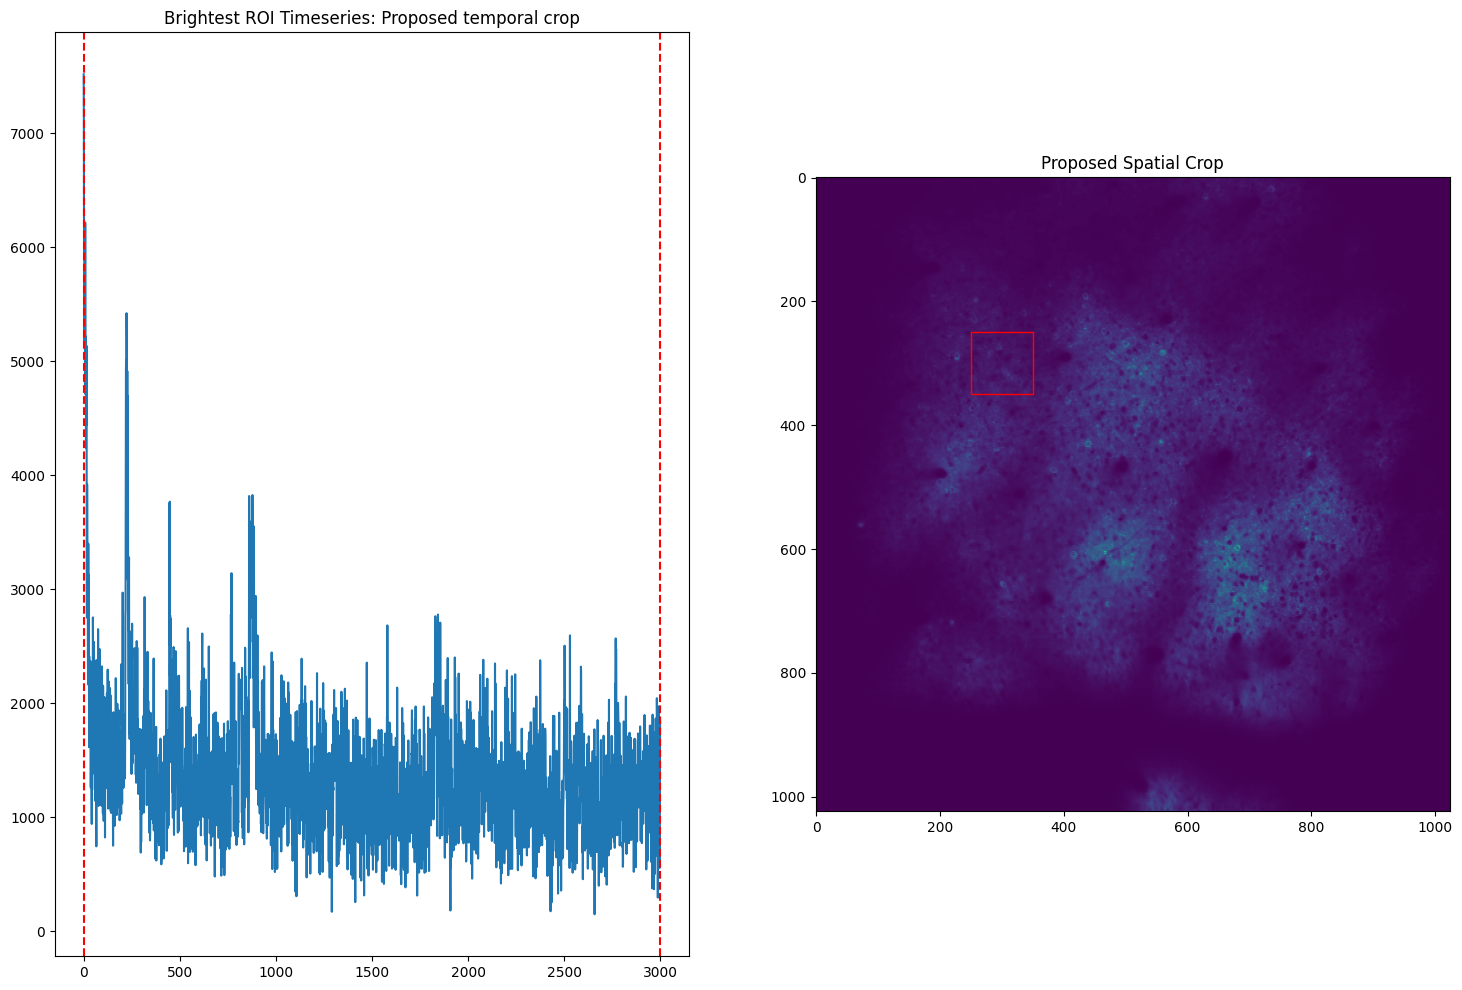

In [5]:
### Paramemters to modify:
start, end = 0, raw_data_loader.shape[0] #Temporally cropping the fov
dim1_slice = [250, 350] #Trimming the "height" of the field of view
dim2_slice = [250, 350] #Trimming the "width" of the field of view
###


#Temporal crop error handling
start = max(0, start)
end = min(end, raw_data_loader.shape[0])

#Spatial crop error handling
dim1_slice[0] = max(dim1_slice[0], 0)
dim2_slice[0] = max(dim2_slice[0], 0)
dim1_slice[1] = min(dim1_slice[1], raw_data_loader.shape[1])
dim2_slice[1] = min(dim2_slice[1], raw_data_loader.shape[2])

def max_roi_average(ndarray):
    # Identify the brightest pixel in the first frame
    brightest_pixel = np.unravel_index(np.argmax(ndarray[0]), ndarray[0].shape)
    x, y = brightest_pixel

    # Define the boundaries of the 3x3 ROI
    x_min = max(x - 1, 0)
    x_max = min(x + 2, ndarray.shape[1])
    y_min = max(y - 1, 0)
    y_max = min(y + 2, ndarray.shape[2])

    # Extract the 3x3 ROI and compute the average over time
    roi = ndarray[:, x_min:x_max, y_min:y_max]
    roi_average = np.mean(roi, axis=(1, 2))

    return roi_average



representative_timeseries = max_roi_average(raw_data_loader)
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
ax[0].plot(representative_timeseries)
ax[0].set_title("Brightest ROI Timeseries: Proposed temporal crop")
ax[0].axvline(x=start, color='red', linestyle='--')
ax[0].axvline(x=end, color='red', linestyle='--')

mean_img = np.mean(raw_data_loader[:1000], axis = 0)
ax[1].imshow(mean_img)

rect = patches.Rectangle([dim1_slice[0], dim2_slice[0]], dim2_slice[1] - dim2_slice[0], dim1_slice[1] - dim1_slice[0], 
                         linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)
ax[1].set_title("Proposed Spatial Crop")
plt.show()

raw_dataloader_crop = raw_data_loader[start:end, dim1_slice[0]:dim1_slice[1], dim2_slice[0]:dim2_slice[1]]

# Run motion correction to identify the data template

In [6]:
# These parameters are for rigid registration
max_shifts = (7, 7)
frames_per_split = 500
num_splits_to_process_rig = 5
niter_rig = 4
save_movie = False

##These parameters are for estimating a piecewise rigid template
pw_rigid = False
strides = (50, 50)
overlaps = (5, 5)
max_deviation_rigid = 5
corrector = jnc.MotionCorrect(raw_dataloader_crop, max_shifts=max_shifts, frames_per_split=frames_per_split,
                                                num_splits_to_process_rig=num_splits_to_process_rig, strides=strides,
                                                       overlaps=overlaps, max_deviation_rigid = max_deviation_rigid, niter_rig=niter_rig, pw_rigid = pw_rigid)



frame_corrector, output_file = corrector.motion_correct(
    template=None, save_movie=save_movie
)

motion_correction_dataloader = jnc.RegistrationArray(frame_corrector, raw_dataloader_crop, pw_rigid=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.63it/s]


# Given the template, run fused motion correction + PMD compression & denoising

In [14]:
block_sizes = [32, 32]
frame_range = 5000
max_components = 20
background_rank = 3

full_pmd_movie = localmd.decomposition.localmd_decomposition(motion_correction_dataloader, block_sizes, frame_range, max_components=max_components, 
                          background_rank=background_rank, sim_conf=5, frame_batch_size = 1000,
                          dtype='float32', pixel_batch_size=5000, max_consecutive_failures = 1, rank_prune=True, temporal_avg_factor=10)

# Visualize the results using fastplotlib

In [13]:
'''
Modify the below timeslice value; this amount of motion corrected, PMD, and High-Passed PMD data is loaded into RAM for the visualization
If you want to load the full dataset, set timeslice = slice(0, raw_data_loader_crop.shape[0])
'''

movies = [raw_dataloader_crop,
          motion_correction_dataloader,
          full_pmd_movie]

iw = ImageWidget(data=movies, 
                 figure_shape=(1,3),
                 names=['Raw', 'Moco', 'PMD'],
                histogram_widget=False)

iw.show()


# Save the results to a .npz file. This file will be loaded by the demixing workflow to extract ROI and Signals

In [10]:
filename = f"Decomposition_File_{dim1_slice[0]}_{dim1_slice[1]}_{dim2_slice[0]}_{dim2_slice[1]}.npz"
np.savez(filename, pmd = full_pmd_movie)